In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def contact_map_generation(filename):
    contact_map = pd.read_csv(filename, header = None, sep = "\t")
    print(contact_map.shape)
    rows,cols = contact_map.shape
#     contact_map.head()
    plt.figure()
    plt.matshow(contact_map)
    plt.show()
    return contact_map

def masking_contactMap(mask, contact_map):
    for a in range(mask, contact_map.shape[0]-mask):
        contact_map.iloc[a, a] = 100
        for b in range(mask):
            contact_map.iloc[a, a-(b+1)] = 100
            contact_map.iloc[a, a+(b+1)] = 100
    plt.figure()
    plt.matshow(contact_map)
    plt.show()
    return contact_map

def thresholding_contactMap(threshold, contact_map):
    contact_map_thresh = contact_map[contact_map < threshold]
    plt.figure()
    plt.matshow(contact_map_thresh)
    plt.show()
    return contact_map_thresh

def graphing_contactMap(mask, threshold, contact_map):
    contact_map_mask = masking_contactMap(mask, contact_map)
    contact_map_thresh = thresholding_contactMap(threshold, contact_map_mask)
    print(contact_map_thresh.shape)
    return contact_map_thresh

# Contact Map Generation
## Cox1a

(1106, 1106)


<Figure size 432x288 with 0 Axes>

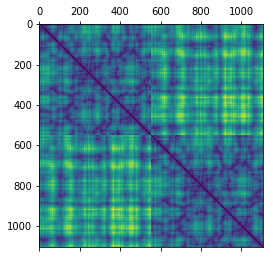

<Figure size 432x288 with 0 Axes>

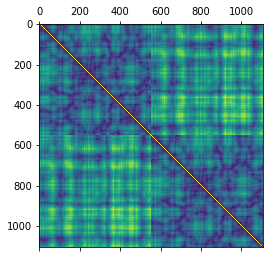

<Figure size 432x288 with 0 Axes>

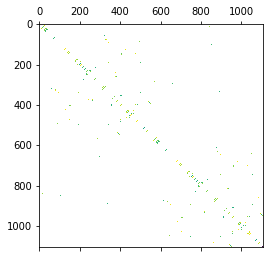

(1106, 1106)


In [2]:
filename = '../data/DataTable_3n8v.txt'
cox1a_contact_map = contact_map_generation(filename)
cox1a_contact_map_thresh = graphing_contactMap(3, 8.0, cox1a_contact_map)

## APRT (length 179)

(179, 179)


<Figure size 432x288 with 0 Axes>

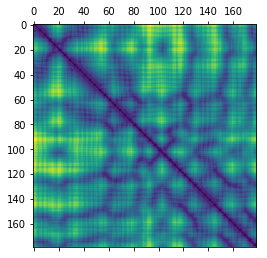

<Figure size 432x288 with 0 Axes>

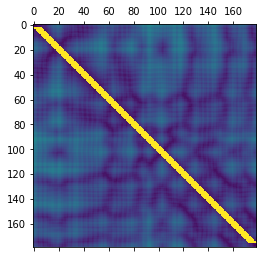

<Figure size 432x288 with 0 Axes>

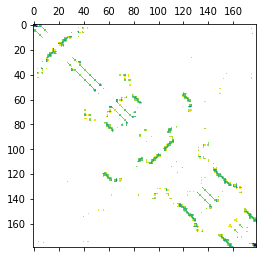

(179, 179)


In [3]:
filename = '../data/DataTable_1ORE.txt'
aprt_contact_map = contact_map_generation(filename)
aprt_contact_map_thresh = graphing_contactMap(3, 8.0, aprt_contact_map)

## DHODH (length 359)

In [ ]:
filename = '../data/DataTable_5K9D.txt'
dhodh_contact_map = contact_map_generation(filename)
dhodh_contact_map_thresh = graphing_contactMap(3, 8.0, dhodh_contact_map)

# Finding mutual information from sequence alignment

We will use MSA on the following regions for the respective proteins:

Cox1 : 350:1350

APRT: 900:1450

DHODH: 200:1600




In [4]:
from math import log
from collections import Counter

def readIn_csv(filename):
    df = pd.read_csv(filename,header = None)
    df_1 = pd.read_csv(filename,header = None)
    df = df.drop([0], axis = 1)
    print(df.shape)
    print(df.head())
    return df, df_1

def non_gaps_freq(df, savename):
    gap_counts = df[df == '-'].count()
    non_gap_counts_freq = 1 - gap_counts/df.shape[0]
    plt.figure()
    plt.bar(df.columns,non_gap_counts_freq)
    plt.ylim(0,1.0)
    plt.ylabel('Frequency of non-gaps')
    plt.xlabel('Amino Acid position')
    plt.savefig('Figures/non_gaps'+savename)
    return non_gap_counts_freq

def MI(seq_list, chosen_cols, rows, i, j):
#     print([i, j])
#     print(chosen_cols)
    if i+1 in chosen_cols and j+1 in chosen_cols:
        Pi = Counter(s[i] for s in seq_list)
#         print(Pi)
        Pj = Counter(s[j] for s in seq_list)
#         print(Pj)
        Pij = Counter((s[i],s[j]) for s in seq_list)
#         print(Pij)
        
        return sum(Pij[(x,y)]/rows * log((Pij[(x,y)]/rows)/(Pi[x]/rows*Pj[y]/rows)) for x,y in Pij)

def MI_histogram(results_table, savename):
    results_1d = results_table.flatten()[~np.isnan(results_table.flatten())]
    plt.figure()
    plt.hist(results_1d)
    plt.ylabel("Frequency")
    plt.xlabel("Mutual Information")
    plt.savefig('Figures/MutualInfo_hist'+savename)
    return results_1d
    
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    flat = np.nan_to_num(flat)
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(flat[indices])]
    return np.unravel_index(indices, ary.shape)

def MI_plot_largeIndices(results_table, cols, savename, n = 6000):
    sort_ind = largest_indices(results_table,n)
    sorted_results = (results_table[sort_ind])
    print(len(sorted_results))
    results_table_2 = np.zeros([cols, cols])
    for a in range(1,len(sorted_results)):
        inds = np.where(results_table == sorted_results[a])
    #     print(inds)
        for b in range(len(inds)):
            if len(inds[b]) == 2:
                results_table_2[inds[b][0],inds[b][1]] = sorted_results[a]
    results_table_2[results_table_2 == 0] = 'nan'
    plt.figure()
    plt.matshow(results_table_2)
    plt.xlabel('Amino Acid i')
    plt.ylabel('Amino Acid j')
    plt.savefig('Figures/MutualInfo_largeInds'+savename)
    return results_table_2

def correlate_distance_MI(MI_results, contact_map, n, savename):
    xy_MI_distance = np.zeros([MI_results.shape[0], 2])
    for a in range(MI_results.shape[0]):
        for b in range(MI_results.shape[1]):
            xy_MI_distance[a,0] = MI_results[a,b]
            xy_MI_distance[a,1] = contact_map.iloc[a,b]
    plt.figure()
    plt.scatter(xy_MI_distance[:,0], xy_MI_distance[:,1], s = 5)
    plt.xlabel('Mutual Information')
    plt.ylabel('Distance (Angstroms)')
    plt.savefig('Figures/corr_distance_MI'+str(savename))
    return xy_MI_distance

def calc_MI(df, contact_map, savename, gap_threshold = 0.2, n = 6000):
    non_gap_counts_freq = non_gaps_freq(df, savename)
    chosen_cols = df.columns[non_gap_counts_freq >= gap_threshold]
#     return chosen_cols
#     print(chosen_cols)
    rows,cols = df.shape
    List_i = range(0,cols)
    List_j = range(0,cols)
    seq_list = df.to_string(header=False, index=False,index_names=False).split('\n')
    seq_list = [s.replace(" ","") for s in seq_list]
    results_table = np.zeros([cols, cols])
    for a in range(len(List_i)):
        for b in range(len(List_j)):
            results_table[a,b] = MI(seq_list, chosen_cols, rows, List_i[a], List_j[b])
    plt.figure()
    plt.matshow(results_table)
    plt.xlabel("Amino Acid i")
    plt.ylabel("Amino Acid j")
    plt.savefig('Figures/MutualInfo_all'+savename)
    results_1d = MI_histogram(results_table, savename)    
    results_table_2 = MI_plot_largeIndices(results_table, cols, savename, n)
    contact_rows, contact_cols = contact_map.shape
    length = min(len(chosen_cols), contact_rows)
    print(length)
    MI_results_abrgd = results_table[np.ix_(chosen_cols[:length], chosen_cols[:length])]
    contact_results_abrdgd = contact_map.iloc[0:length,0:length]
    print(MI_results_abrgd.shape)
    print(contact_results_abrdgd.shape)
    xy_MI_distance = correlate_distance_MI(MI_results_abrgd, contact_results_abrdgd, n, savename)
    return results_table, results_table_2, xy_MI_distance



## Cox1

(96, 1000)
  1    2    3    4    5    6    7    8    9    10   ...  991  992  993  994   \
0    -    -    -    -    -    -    -    -    -    - ...     -    -    -    -   
1    -    -    -    -    -    -    -    -    -    - ...     -    -    -    -   
2    -    -    -    -    -    -    -    -    -    - ...     -    -    -    -   
3    -    -    -    -    -    -    -    -    -    - ...     -    -    -    -   
4    -    -    -    -    -    -    -    -    -    - ...     -    -    -    -   

  995  996  997  998  999  1000  
0    -    -    -    -    -    -  
1    -    -    -    -    -    -  
2    -    -    -    -    -    -  
3    -    -    -    -    -    -  
4    -    -    -    -    -    -  

[5 rows x 1000 columns]
6000
529
(529, 529)
(529, 529)


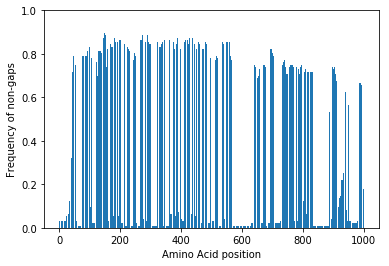

<Figure size 432x288 with 0 Axes>

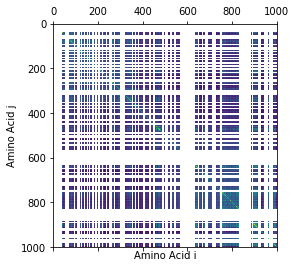

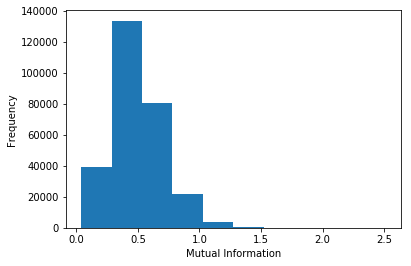

<Figure size 432x288 with 0 Axes>

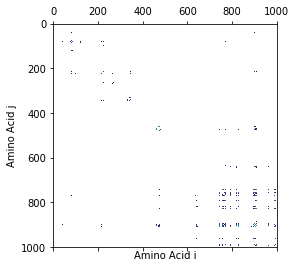

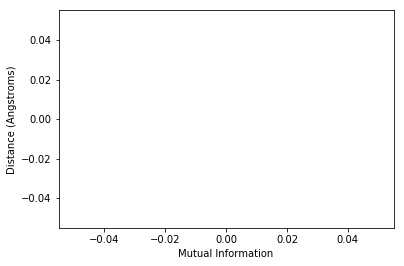

In [5]:
df_cox1, df_cox1_1 = readIn_csv('../data/alignment_Data/muscle_cox1_processed.csv')
MI_results_cox1, MI_results_cox1_largeIndices, cox1_MI_dist = calc_MI(df_cox1, cox1a_contact_map, '_cox1.jpg', 0.2, 6000)

In [6]:
cox1_MI_dist

array([[         nan,  59.24124146],
       [         nan,  56.07482529],
       [         nan,  52.73324966],
       ...,
       [         nan, 100.        ],
       [         nan, 100.        ],
       [         nan, 100.        ]])

## APRT

In [ ]:
df_aprt, df_aprt_1 = readIn_csv('../data/alignment_Data/muscle_aprt_processed.csv')
MI_results_aprt, MI_results_aprt_largeIndices = calc_MI(df_aprt, '_aprt.jpg', 0.2, 6000)

## DHODH

In [ ]:
df_dhodh, df_dhodh_1 = readIn_csv('../data/alignment_Data/muscle_DHODH_processed.csv')
MI_results_dhodh, MI_results_dhodh_largeIndices = calc_MI(df_dhodh, '_dhodh.jpg', 0.2, 6000)